# Report on CODS analysis

- We perform the CODS analysis w/ bootstraping (assuming 512 realizations) for our synthetic datasets

In [3]:
# In the root of the repo run "pip install --editable ."

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from src.data.import_data import import_df_from_zip_pkl, import_df_info_from_zip, import_df_info_from_zip, import_cods_instance_from_zip_pkl
from src.models.cods_analysis import load_cods_results
import rdtools
import pickle
import time
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import mean_squared_error
import numpy as np
from matplotlib.offsetbox import AnchoredText
import matplotlib as mpl
label_size = 16
mpl.rcParams["xtick.labelsize"] = label_size 
mpl.rcParams["ytick.labelsize"] = label_size 

In [8]:
def cods_process_results_one(path_to_data, path_to_pi, path_to_cods, index=0, 
                             clipping="1", realizations=512, verbose=True):
    
    """
    """
    
    # synthetic time series
    df = import_df_from_zip_pkl(path_to_data, index=index, verbose=verbose)
    df_info = import_df_info_from_zip(path_to_data, verbose=verbose)
    rd_true = df_info.Degradation_rate_linear.iloc[index]*100
    
    # normalized time series
    df_norm = import_df_from_zip_pkl(path_to_pi, index=index, verbose=verbose, minofday=False)
    
    # cods instance
    cods_instance = import_cods_instance_from_zip_pkl(path_to_cods, index=index, verbose=verbose)
    result_df     = cods_instance.result_df
    
    # PI
    pi_est        = result_df.total_model
    if clipping=="1":
        pi_true = df_norm.PI_clipping_basic
    elif clipping=="2":
        pi_true = df_norm.PI_clipping_flexible
    elif clipping=="3":
        pi_true = df_norm.PI_clipping_universal
    else:
        sys.exit("Function for removing clipping not implemented!")
    
    _pi_mask = np.logical_and(pi_true.notna(), pi_est.notna())
    _pi_mask[_pi_mask.isna()]=False 
    #print(pi_true.notna()[:10], pi_est.notna()[:10])
    #print(pi_true[_pi_mask].isna().sum())
    #print(pi_est[_pi_mask].isna().sum())

    #print(pi_true.notna().sum() / pi_true.size)
    #print(pi_est.notna().sum() / pi_est.size)
    #print(_pi_mask.sum())    
    
    rmse_pi = mean_squared_error(pi_true[_pi_mask], pi_est[_pi_mask], squared=False)
    # Degradation rate
    rd_est  = cods_instance.degradation
    rmse_rd = mean_squared_error([rd_true], [rd_est[0]], squared=False)
    # Soiling
    sr_est  = result_df.soiling_ratio
    sr_true = df_norm.Soiling
    rmse_sr = mean_squared_error(sr_true[_pi_mask], sr_est[_pi_mask], squared=False)
    
    return ([rmse_pi, pi_true, pi_est], [rmse_rd, rd_true, rd_est], [rmse_sr, sr_true, sr_est])

def find_extrema_rmse(rmse, true, est):
    """
    """
    index_min = np.argmin(rmse)
    index_max = np.argmax(rmse)
    min_true  = true[index_min]
    min_est   = est[index_min]
    max_true  = true[index_max]
    max_est   = est[index_max]
    
    return (index_min, index_max, min_true, min_est, max_true, max_est)

def cods_process_results_all(path_to_data, path_to_pi, path_to_cods, clipping="1", 
                             realizations=512, verbose=False):
    rmse_pi = np.zeros(50)
    rmse_rd = np.zeros(50)
    rmse_sr = np.zeros(50)
    pi_true = {}
    pi_est  = {}
    rd_true = np.zeros(50)
    rd_est  = np.zeros((50, 3))
    sr_true = {}
    sr_est  = {}
    for i in range(0, 50):
        _pi, _rd, _sr = cods_process_results_one(path_to_data, path_to_pi, path_to_cods, index=i, realizations=realizations, 
                                                 clipping=clipping, verbose=verbose)
        rmse_pi[i]    = _pi[0]
        rmse_rd[i]    = _rd[0]
        rmse_sr[i]    = _sr[0]
        pi_true[i]    = _pi[1]
        pi_est[i]     = _pi[2]
        rd_true[i]    = _rd[1]
        rd_est[i]     = _rd[2]
        sr_true[i]    = _sr[1]
        sr_est[i]     = _sr[2]
    # Find best and worst PI time series 
    index_min, index_max, min_true, min_est, max_true, max_est = find_extrema_rmse(rmse_pi, pi_true, pi_est)
    pi = [rmse_pi[index_min], rmse_pi[index_max], min_true, min_est, max_true, max_est]
    # Find best and worst SR time series
    index_min, index_max, min_true, min_est, max_true, max_est = find_extrema_rmse(rmse_sr, sr_true, sr_est)
    sr = [rmse_sr[index_min], rmse_sr[index_max], min_true, min_est, max_true, max_est]
    
    return (pi, [rmse_rd, rd_true, rd_est], sr)

## Basic w/ basic clipping and no outlier removal

In [23]:
pi, rd, sr = cods_process_results_all('../data/raw/synthetic_basic.zip', '../data/raw/synthetic_basic_pi_daily.zip', '../data/processed/cods_results_basic_r512_c1_o000.zip', 
                                      realizations=512, clipping="1", verbose=False)

**Performance index**

/home/maria/miniconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


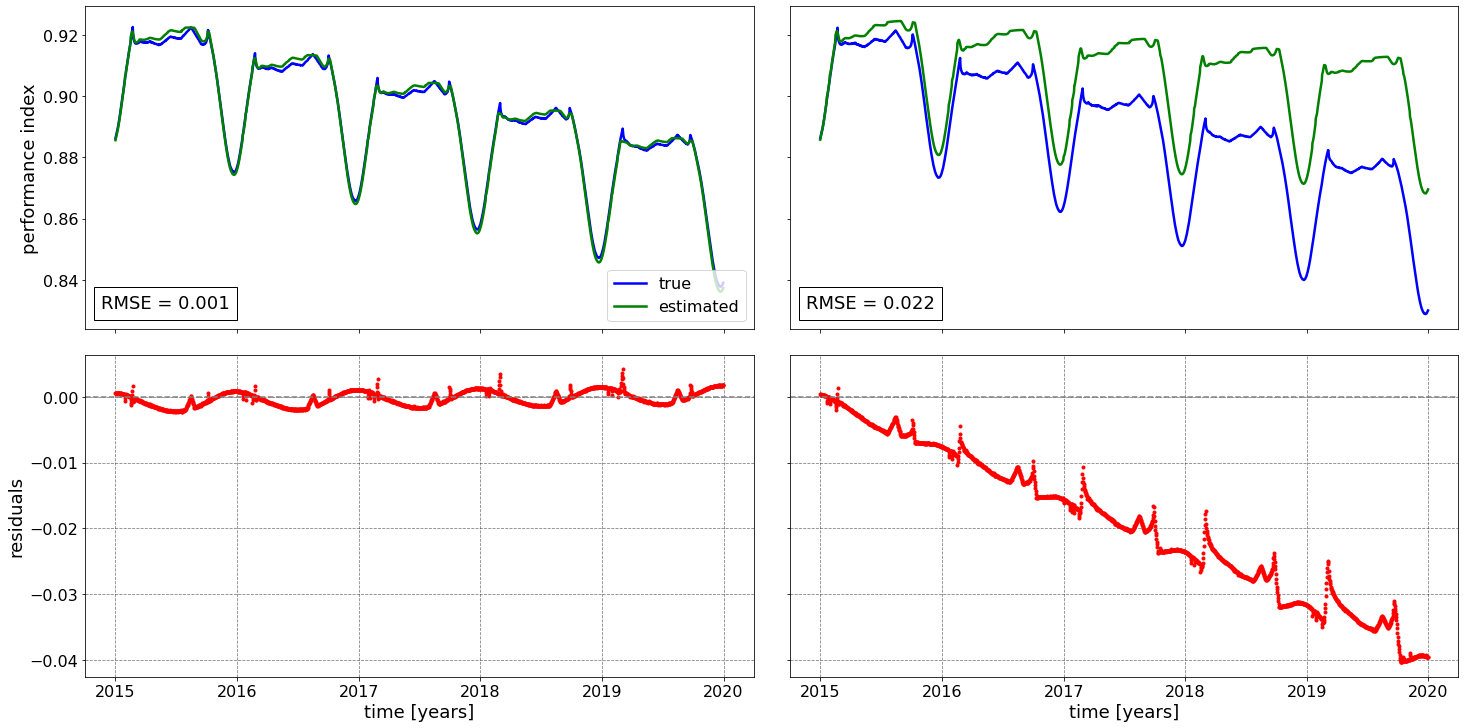

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey="row")
fig.tight_layout()


ax[0, 0].plot(pi[2].index, pi[2], color="blue", lw=2.5, ls="-", label="true")
ax[0, 0].plot(pi[3].index, pi[3], color="green", lw=2.5, ls="-", label="estimated")
ax[1, 0].plot(pi[2].index, pi[2]-pi[3], "r.")
text = AnchoredText(("RMSE = %.3f" %pi[0]), loc=3, prop=dict(size=18))
ax[0, 0].add_artist(text)
ax[0, 0].legend(loc=4, fontsize=16)

ax[0, 1].plot(pi[4].index, pi[4], color="blue", lw=2.5, ls="-", label="true")
ax[0, 1].plot(pi[5].index, pi[5], color="green", lw=2.5, ls="-", label="estimated")
ax[1, 1].plot(pi[4].index, pi[4]-pi[5], "r.")
text = AnchoredText(("RMSE = %.3f" %pi[1]), loc=3, prop=dict(size=18))
ax[0, 1].add_artist(text)

ax[0, 0].set_ylabel("performance index", fontsize=18)
ax[1, 0].set_ylabel("residuals", fontsize=18)
ax[1, 0].set_xlabel("time [years]", fontsize=18)
ax[1, 1].set_xlabel("time [years]", fontsize=18)
ax[1, 0].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1, 0].axhline(0., color="grey", ls="--")
ax[1, 1].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1, 1].axhline(0., color="grey", ls="--")

**Degradation rate**

the RMSE for the degradation rate is 0.365 percentage/year


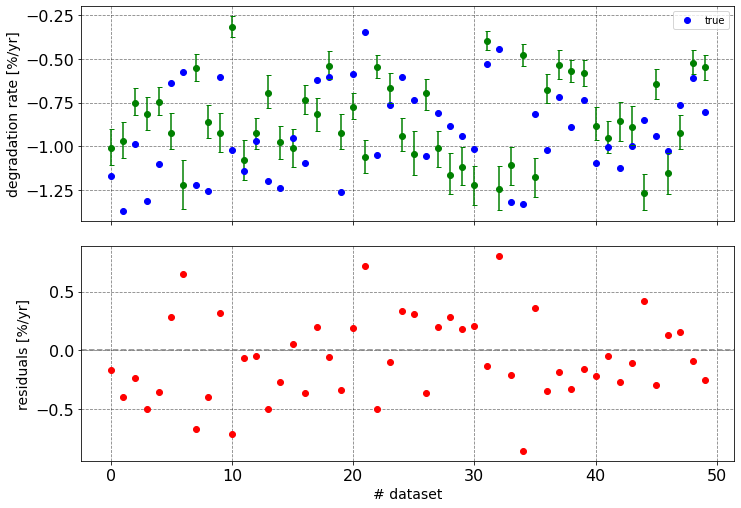

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
fig.tight_layout()

ax[0].plot(rd[1], "bo", label="true")
ax[0].errorbar(np.arange(0, 50), rd[2][:, 0], yerr=[rd[2][:, 0]-rd[2][:, 1], rd[2][:, 2]-rd[2][:, 0]], 
               fmt="o", color="green", capsize=2.5)
#ax[0].plot(rd[2][:, 0], "go", label="estimated")
#ax[0].fill_between(np.arange(0, 50), rd[2][:, 1], rd[2][:, 2], color="green", alpha=0.4)
ax[1].plot(rd[1]-rd[2][:, 0], "ro")
ax[0].legend()

ax[0].set_ylabel("degradation rate [%/yr]", fontsize=14)
ax[1].set_ylabel("residuals [%/yr]", fontsize=14)
ax[1].set_xlabel("# dataset", fontsize=14)
ax[0].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1].axhline(0., color="grey", ls="--")

rmse_rd = mean_squared_error(rd[1], rd[2][:, 0], squared=False)
print ("the RMSE for the degradation rate is %.3f percentage/year" %rmse_rd)

Text(0, 0.5, 'counts')

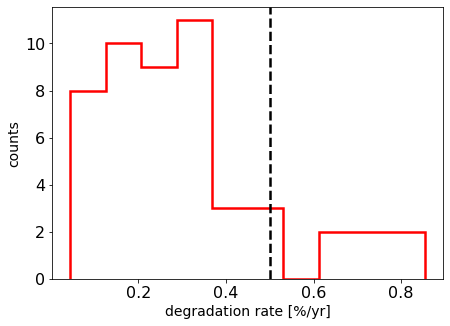

In [16]:
fig, ax = plt.subplots(figsize=(7, 5))
_, _, _ = ax.hist(rd[0], histtype="step", linewidth=2.5, color="red")
ax.axvline(0.5, lw=2.5, color="k", ls="--")
ax.set_xlabel("degradation rate [%/yr]", fontsize=14)
ax.set_ylabel("counts", fontsize=14)

**Soiling profile**

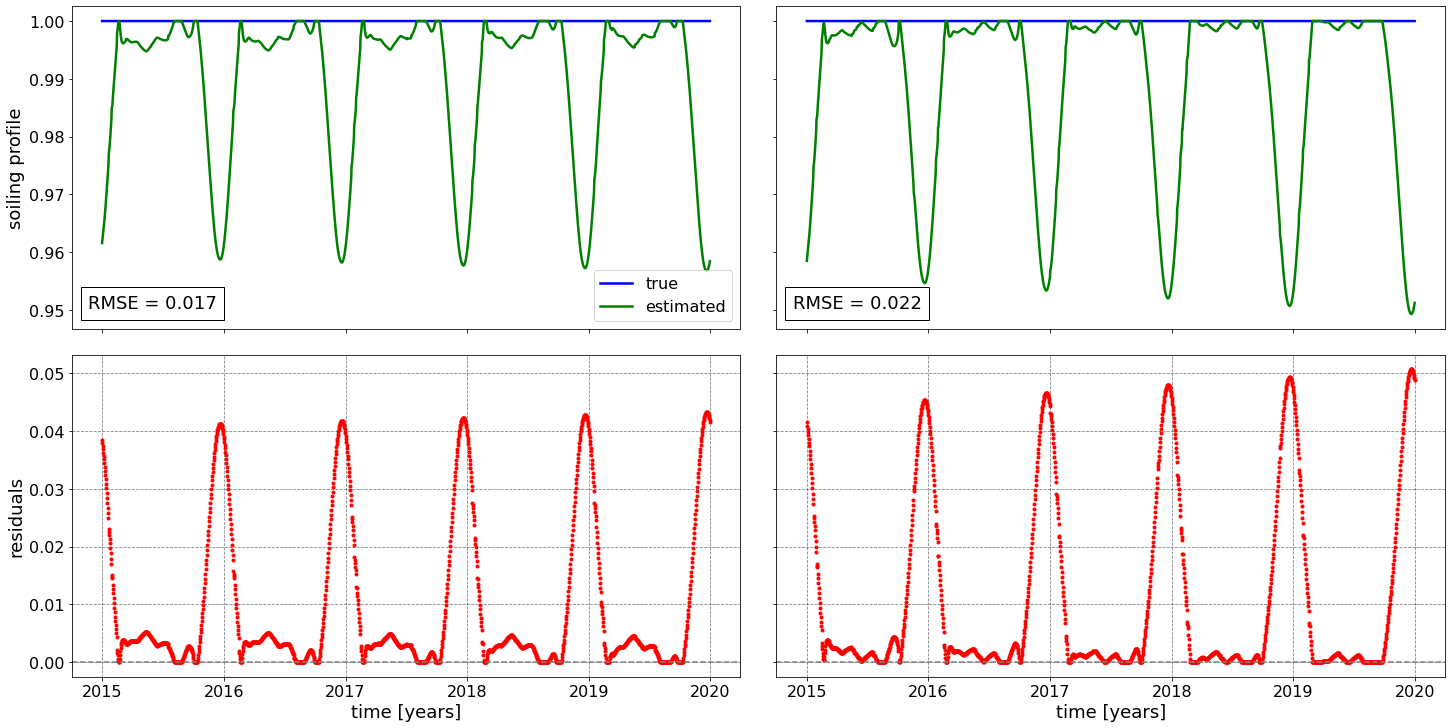

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey="row")
fig.tight_layout()


ax[0, 0].plot(sr[2].index, sr[2], color="blue", lw=2.5, ls="-", label="true")
ax[0, 0].plot(sr[3].index, sr[3], color="green", lw=2.5, ls="-", label="estimated")
ax[1, 0].plot(sr[2].index, sr[2]-sr[3], "r.")
text = AnchoredText(("RMSE = %.3f" %sr[0]), loc=3, prop=dict(size=18))
ax[0, 0].add_artist(text)
ax[0, 0].legend(loc=4, fontsize=16)

ax[0, 1].plot(sr[4].index, sr[4], color="blue", lw=2.5, ls="-", label="true")
ax[0, 1].plot(sr[5].index, sr[5], color="green", lw=2.5, ls="-", label="estimated")
ax[1, 1].plot(sr[4].index, sr[4]-sr[5], "r.")
text = AnchoredText(("RMSE = %.3f" %pi[1]), loc=3, prop=dict(size=18))
ax[0, 1].add_artist(text)

ax[0, 0].set_ylabel("soiling profile", fontsize=18)
ax[1, 0].set_ylabel("residuals", fontsize=18)
ax[1, 0].set_xlabel("time [years]", fontsize=18)
ax[1, 1].set_xlabel("time [years]", fontsize=18)
ax[1, 0].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1, 0].axhline(0., color="grey", ls="--")
ax[1, 1].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1, 1].axhline(0., color="grey", ls="--")

## Soil w/ basic clipping and w/o outlier removal

In [25]:
pi, rd, sr = cods_process_results_all('../data/raw/synthetic_soil.zip', 
                                      '../data/raw/synthetic_soil_pi_daily.zip', 
                                      '../data/processed/cods_results_soil_r512_c1_o000.zip', 
                                      realizations=512, clipping="1", verbose=False)

**Performance index**

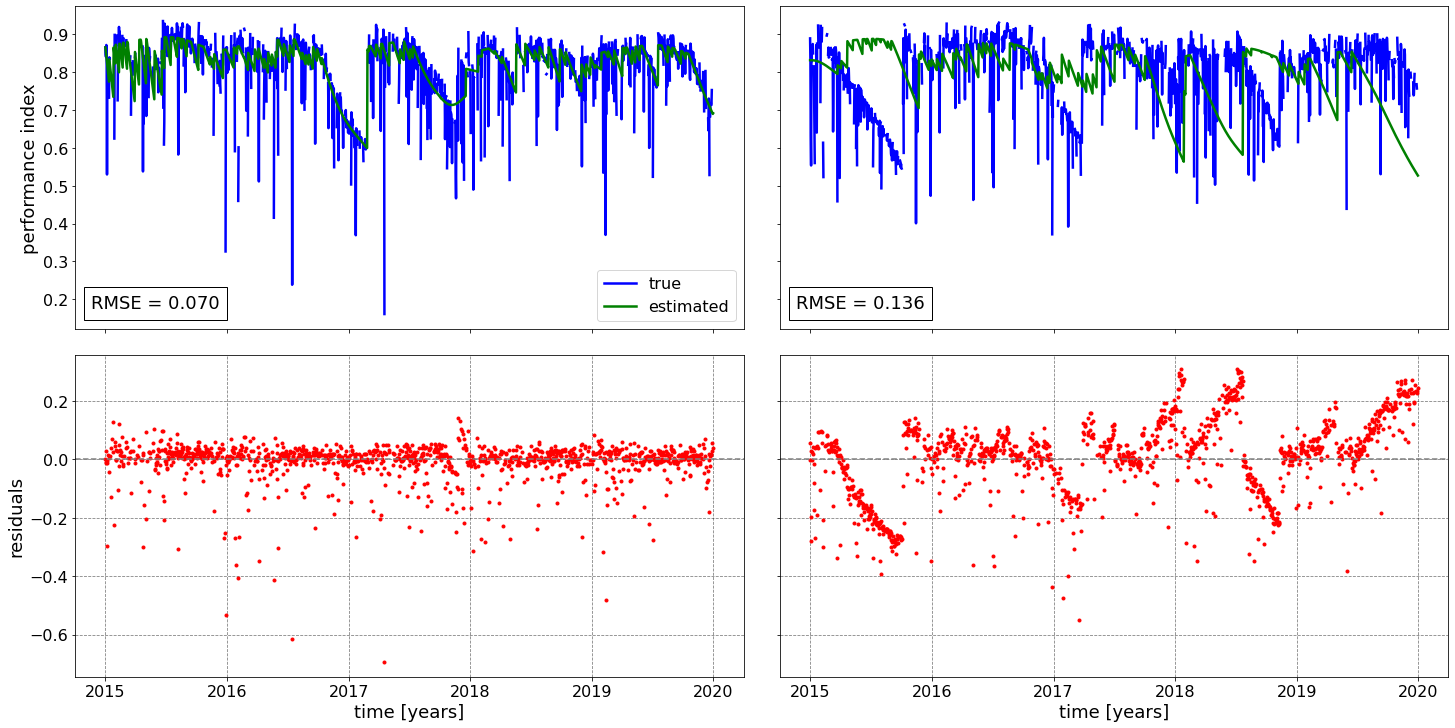

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey="row")
fig.tight_layout()


ax[0, 0].plot(pi[2].index, pi[2], color="blue", lw=2.5, ls="-", label="true")
ax[0, 0].plot(pi[3].index, pi[3], color="green", lw=2.5, ls="-", label="estimated")
ax[1, 0].plot(pi[2].index, pi[2]-pi[3], "r.")
text = AnchoredText(("RMSE = %.3f" %pi[0]), loc=3, prop=dict(size=18))
ax[0, 0].add_artist(text)
ax[0, 0].legend(loc=4, fontsize=16)

ax[0, 1].plot(pi[4].index, pi[4], color="blue", lw=2.5, ls="-", label="true")
ax[0, 1].plot(pi[5].index, pi[5], color="green", lw=2.5, ls="-", label="estimated")
ax[1, 1].plot(pi[4].index, pi[4]-pi[5], "r.")
text = AnchoredText(("RMSE = %.3f" %pi[1]), loc=3, prop=dict(size=18))
ax[0, 1].add_artist(text)

ax[0, 0].set_ylabel("performance index", fontsize=18)
ax[1, 0].set_ylabel("residuals", fontsize=18)
ax[1, 0].set_xlabel("time [years]", fontsize=18)
ax[1, 1].set_xlabel("time [years]", fontsize=18)
ax[1, 0].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1, 0].axhline(0., color="grey", ls="--")
ax[1, 1].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1, 1].axhline(0., color="grey", ls="--")

**Degradation rate**

the RMSE for the degradation rate is 0.530 percentage/year


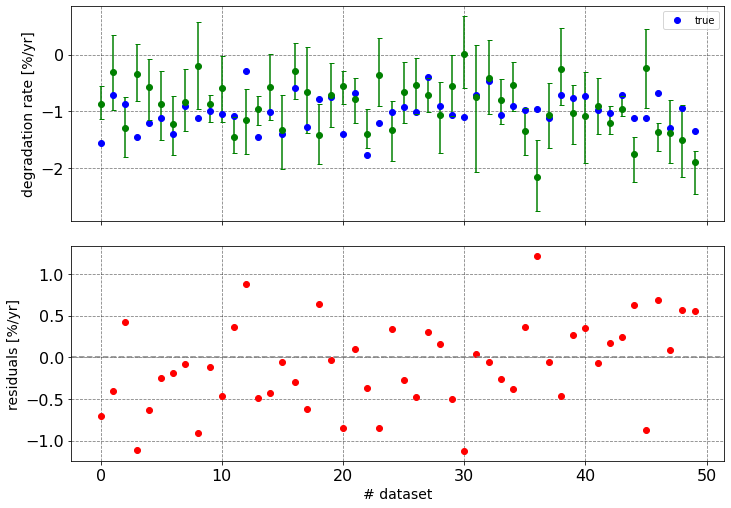

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
fig.tight_layout()

ax[0].plot(rd[1], "bo", label="true")
ax[0].errorbar(np.arange(0, 50), rd[2][:, 0], yerr=[rd[2][:, 0]-rd[2][:, 1], rd[2][:, 2]-rd[2][:, 0]], 
               fmt="o", color="green", capsize=2.5)
#ax[0].plot(rd[2][:, 0], "go", label="estimated")
#ax[0].fill_between(np.arange(0, 50), rd[2][:, 1], rd[2][:, 2], color="green", alpha=0.4)
ax[1].plot(rd[1]-rd[2][:, 0], "ro")
ax[0].legend()

ax[0].set_ylabel("degradation rate [%/yr]", fontsize=14)
ax[1].set_ylabel("residuals [%/yr]", fontsize=14)
ax[1].set_xlabel("# dataset", fontsize=14)
ax[0].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1].axhline(0., color="grey", ls="--")

rmse_rd = mean_squared_error(rd[1], rd[2][:, 0], squared=False)
print ("the RMSE for the degradation rate is %.3f percentage/year" %rmse_rd)

Text(0, 0.5, 'counts')

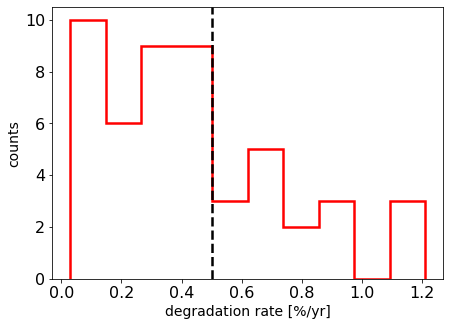

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))
_, _, _ = ax.hist(rd[0], histtype="step", linewidth=2.5, color="red")
ax.axvline(0.5, lw=2.5, color="k", ls="--")
ax.set_xlabel("degradation rate [%/yr]", fontsize=14)
ax.set_ylabel("counts", fontsize=14)

**Soiling profile**

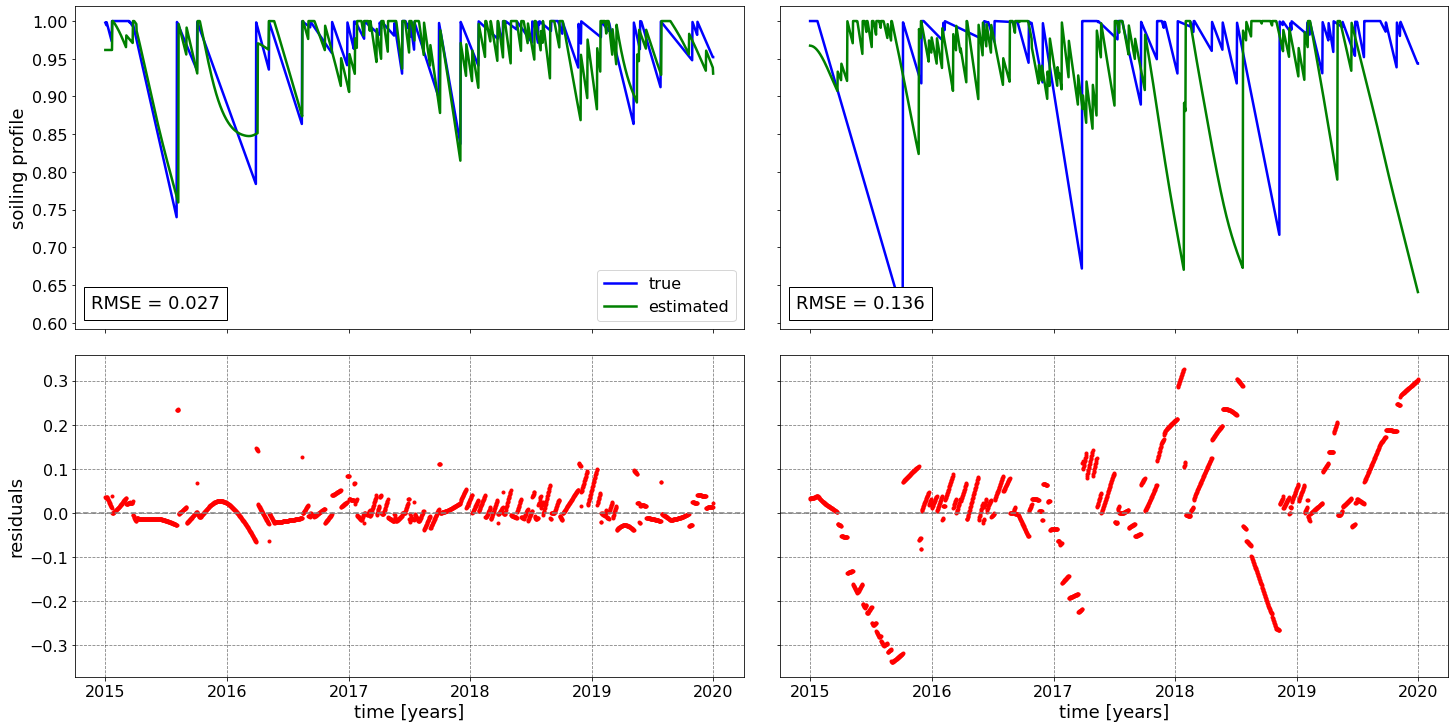

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey="row")
fig.tight_layout()


ax[0, 0].plot(sr[2].index, sr[2], color="blue", lw=2.5, ls="-", label="true")
ax[0, 0].plot(sr[3].index, sr[3], color="green", lw=2.5, ls="-", label="estimated")
ax[1, 0].plot(sr[2].index, sr[2]-sr[3], "r.")
text = AnchoredText(("RMSE = %.3f" %sr[0]), loc=3, prop=dict(size=18))
ax[0, 0].add_artist(text)
ax[0, 0].legend(loc=4, fontsize=16)

ax[0, 1].plot(sr[4].index, sr[4], color="blue", lw=2.5, ls="-", label="true")
ax[0, 1].plot(sr[5].index, sr[5], color="green", lw=2.5, ls="-", label="estimated")
ax[1, 1].plot(sr[4].index, sr[4]-sr[5], "r.")
text = AnchoredText(("RMSE = %.3f" %pi[1]), loc=3, prop=dict(size=18))
ax[0, 1].add_artist(text)

ax[0, 0].set_ylabel("soiling profile", fontsize=18)
ax[1, 0].set_ylabel("residuals", fontsize=18)
ax[1, 0].set_xlabel("time [years]", fontsize=18)
ax[1, 1].set_xlabel("time [years]", fontsize=18)
ax[1, 0].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1, 0].axhline(0., color="grey", ls="--")
ax[1, 1].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1, 1].axhline(0., color="grey", ls="--")

## Weather w/ basic clipping and no outlier removal

In [13]:
pi, rd, sr = cods_process_results_all('../data/raw/synthetic_weather.zip', '../data/raw/synthetic_weather_pi_daily.zip', 
                                      '../data/processed/cods_results_weather_r512_c1_o000.zip', 
                                      realizations=512, clipping="1", verbose=False)

**Performance index**

/home/maria/miniconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


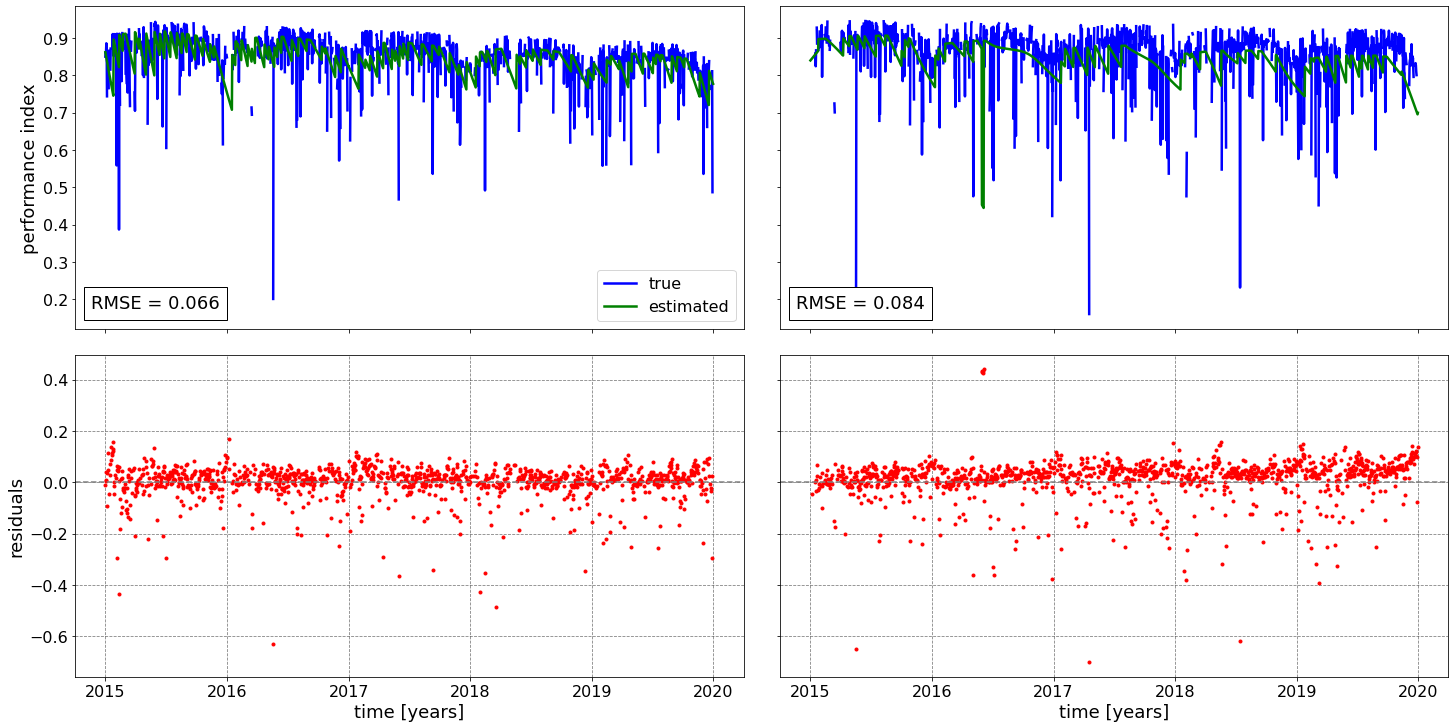

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey="row")
fig.tight_layout()


ax[0, 0].plot(pi[2].index, pi[2], color="blue", lw=2.5, ls="-", label="true")
ax[0, 0].plot(pi[3].index, pi[3], color="green", lw=2.5, ls="-", label="estimated")
ax[1, 0].plot(pi[2].index, pi[2]-pi[3], "r.")
text = AnchoredText(("RMSE = %.3f" %pi[0]), loc=3, prop=dict(size=18))
ax[0, 0].add_artist(text)
ax[0, 0].legend(loc=4, fontsize=16)

ax[0, 1].plot(pi[4].index, pi[4], color="blue", lw=2.5, ls="-", label="true")
ax[0, 1].plot(pi[5].index, pi[5], color="green", lw=2.5, ls="-", label="estimated")
ax[1, 1].plot(pi[4].index, pi[4]-pi[5], "r.")
text = AnchoredText(("RMSE = %.3f" %pi[1]), loc=3, prop=dict(size=18))
ax[0, 1].add_artist(text)

ax[0, 0].set_ylabel("performance index", fontsize=18)
ax[1, 0].set_ylabel("residuals", fontsize=18)
ax[1, 0].set_xlabel("time [years]", fontsize=18)
ax[1, 1].set_xlabel("time [years]", fontsize=18)
ax[1, 0].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1, 0].axhline(0., color="grey", ls="--")
ax[1, 1].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1, 1].axhline(0., color="grey", ls="--")

**Degradation rate**

the RMSE for the degradation rate is 0.478 percentage/year


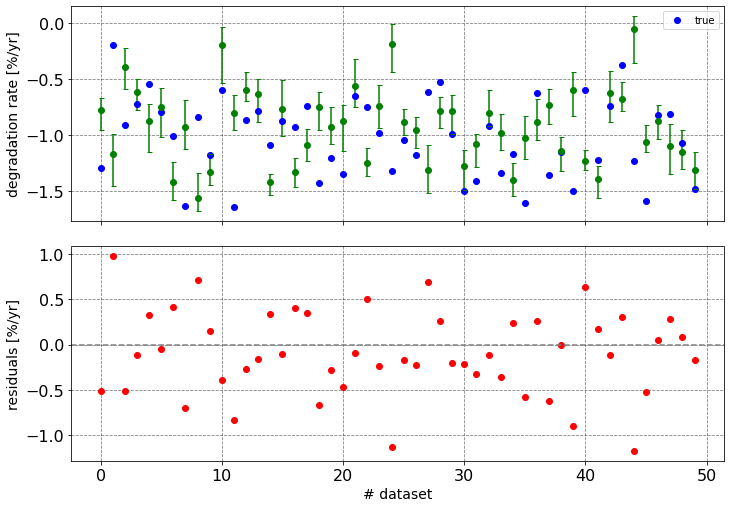

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
fig.tight_layout()

ax[0].plot(rd[1], "bo", label="true")
ax[0].errorbar(np.arange(0, 50), rd[2][:, 0], yerr=[rd[2][:, 0]-rd[2][:, 1], rd[2][:, 2]-rd[2][:, 0]], 
               fmt="o", color="green", capsize=2.5)
#ax[0].plot(rd[2][:, 0], "go", label="estimated")
#ax[0].fill_between(np.arange(0, 50), rd[2][:, 1], rd[2][:, 2], color="green", alpha=0.4)
ax[1].plot(rd[1]-rd[2][:, 0], "ro")
ax[0].legend()

ax[0].set_ylabel("degradation rate [%/yr]", fontsize=14)
ax[1].set_ylabel("residuals [%/yr]", fontsize=14)
ax[1].set_xlabel("# dataset", fontsize=14)
ax[0].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1].axhline(0., color="grey", ls="--")

rmse_rd = mean_squared_error(rd[1], rd[2][:, 0], squared=False)
print ("the RMSE for the degradation rate is %.3f percentage/year" %rmse_rd)

Text(0, 0.5, 'counts')

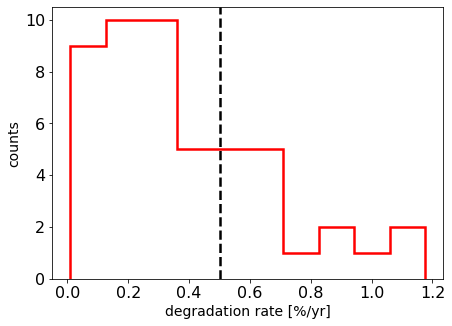

In [16]:
fig, ax = plt.subplots(figsize=(7, 5))
_, _, _ = ax.hist(rd[0], histtype="step", linewidth=2.5, color="red")
ax.axvline(0.5, lw=2.5, color="k", ls="--")
ax.set_xlabel("degradation rate [%/yr]", fontsize=14)
ax.set_ylabel("counts", fontsize=14)

**Soiling profile**

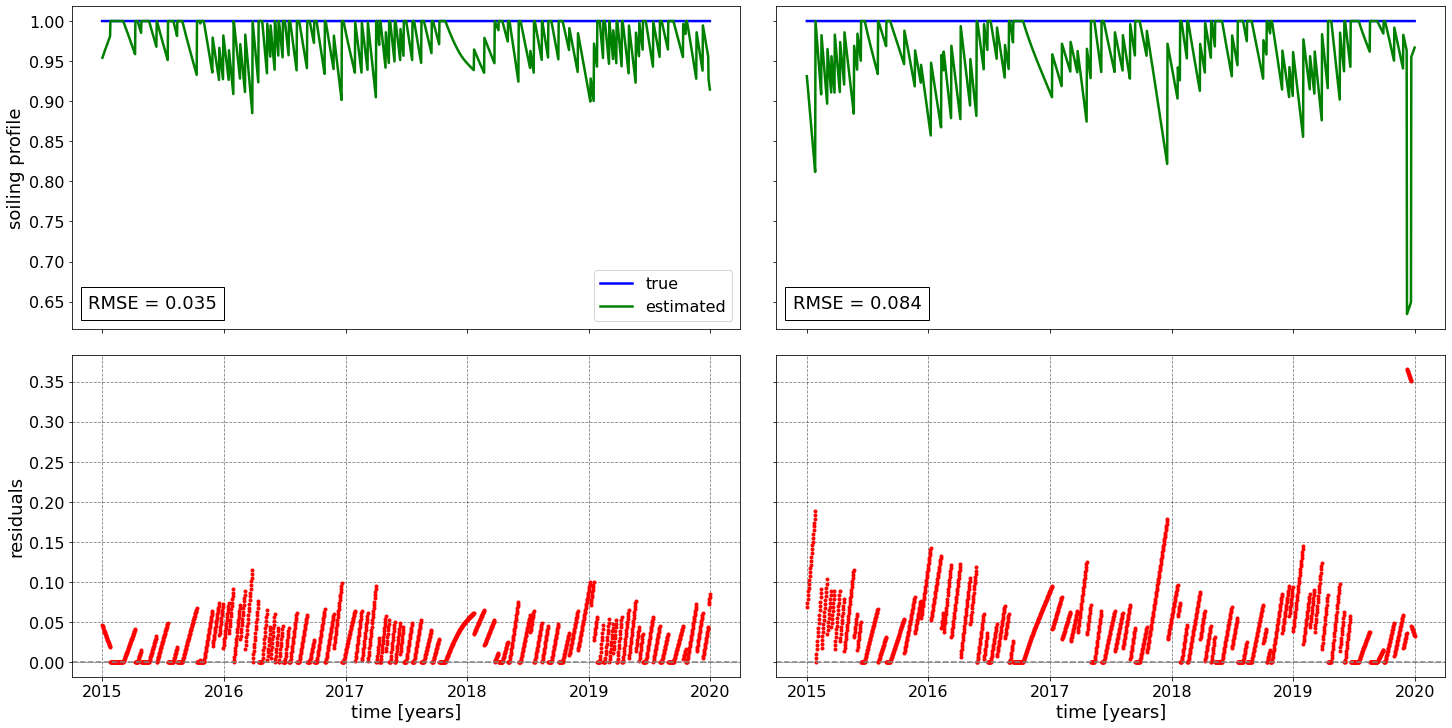

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey="row")
fig.tight_layout()


ax[0, 0].plot(sr[2].index, sr[2], color="blue", lw=2.5, ls="-", label="true")
ax[0, 0].plot(sr[3].index, sr[3], color="green", lw=2.5, ls="-", label="estimated")
ax[1, 0].plot(sr[2].index, sr[2]-sr[3], "r.")
text = AnchoredText(("RMSE = %.3f" %sr[0]), loc=3, prop=dict(size=18))
ax[0, 0].add_artist(text)
ax[0, 0].legend(loc=4, fontsize=16)

ax[0, 1].plot(sr[4].index, sr[4], color="blue", lw=2.5, ls="-", label="true")
ax[0, 1].plot(sr[5].index, sr[5], color="green", lw=2.5, ls="-", label="estimated")
ax[1, 1].plot(sr[4].index, sr[4]-sr[5], "r.")
text = AnchoredText(("RMSE = %.3f" %pi[1]), loc=3, prop=dict(size=18))
ax[0, 1].add_artist(text)

ax[0, 0].set_ylabel("soiling profile", fontsize=18)
ax[1, 0].set_ylabel("residuals", fontsize=18)
ax[1, 0].set_xlabel("time [years]", fontsize=18)
ax[1, 1].set_xlabel("time [years]", fontsize=18)
ax[1, 0].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1, 0].axhline(0., color="grey", ls="--")
ax[1, 1].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1, 1].axhline(0., color="grey", ls="--")

## Soil + Weather w/ basic clipping and outlier removal
In the normalized power input, everything below 0.60 is removed

In [18]:
pi, rd, sr = cods_process_results_all('../data/raw/synthetic_soil_weather.zip', 
                                      '../data/raw/synthetic_soil_weather_pi_daily.zip', 
                                      '../data/processed/cods_results_soil_weather_r512_c1_o060.zip', 
                                      realizations=512, clipping="1", verbose=False)

**Performance index**

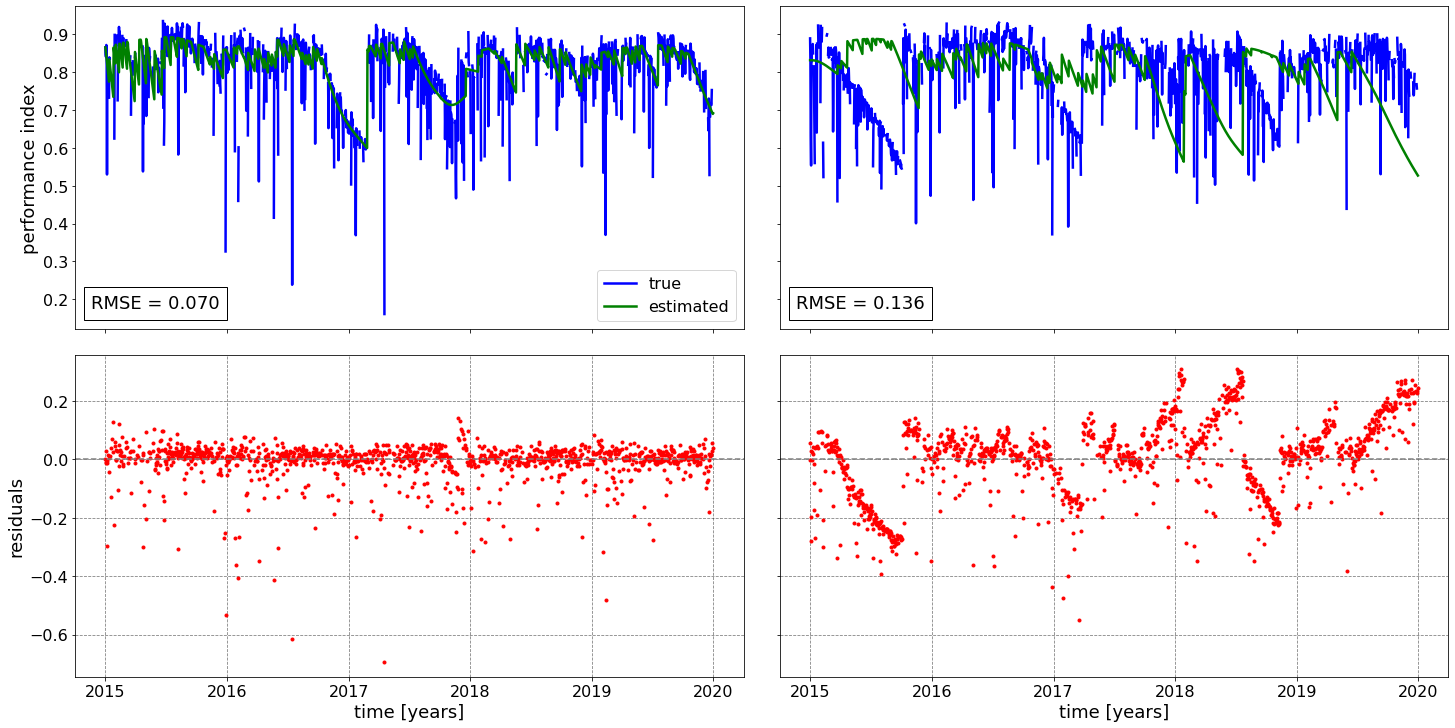

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey="row")
fig.tight_layout()


ax[0, 0].plot(pi[2].index, pi[2], color="blue", lw=2.5, ls="-", label="true")
ax[0, 0].plot(pi[3].index, pi[3], color="green", lw=2.5, ls="-", label="estimated")
ax[1, 0].plot(pi[2].index, pi[2]-pi[3], "r.")
text = AnchoredText(("RMSE = %.3f" %pi[0]), loc=3, prop=dict(size=18))
ax[0, 0].add_artist(text)
ax[0, 0].legend(loc=4, fontsize=16)

ax[0, 1].plot(pi[4].index, pi[4], color="blue", lw=2.5, ls="-", label="true")
ax[0, 1].plot(pi[5].index, pi[5], color="green", lw=2.5, ls="-", label="estimated")
ax[1, 1].plot(pi[4].index, pi[4]-pi[5], "r.")
text = AnchoredText(("RMSE = %.3f" %pi[1]), loc=3, prop=dict(size=18))
ax[0, 1].add_artist(text)

ax[0, 0].set_ylabel("performance index", fontsize=18)
ax[1, 0].set_ylabel("residuals", fontsize=18)
ax[1, 0].set_xlabel("time [years]", fontsize=18)
ax[1, 1].set_xlabel("time [years]", fontsize=18)
ax[1, 0].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1, 0].axhline(0., color="grey", ls="--")
ax[1, 1].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1, 1].axhline(0., color="grey", ls="--")

**Degradation rate**

the RMSE for the degradation rate is 0.530 percentage/year


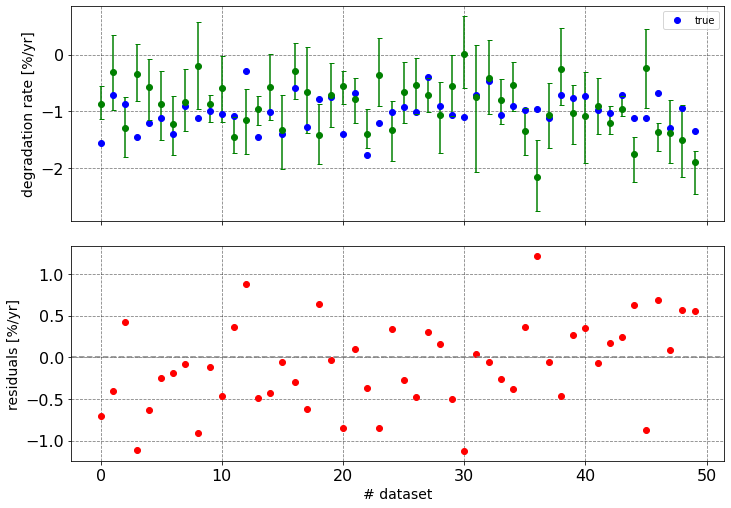

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
fig.tight_layout()

ax[0].plot(rd[1], "bo", label="true")
ax[0].errorbar(np.arange(0, 50), rd[2][:, 0], yerr=[rd[2][:, 0]-rd[2][:, 1], rd[2][:, 2]-rd[2][:, 0]], 
               fmt="o", color="green", capsize=2.5)
#ax[0].plot(rd[2][:, 0], "go", label="estimated")
#ax[0].fill_between(np.arange(0, 50), rd[2][:, 1], rd[2][:, 2], color="green", alpha=0.4)
ax[1].plot(rd[1]-rd[2][:, 0], "ro")
ax[0].legend()

ax[0].set_ylabel("degradation rate [%/yr]", fontsize=14)
ax[1].set_ylabel("residuals [%/yr]", fontsize=14)
ax[1].set_xlabel("# dataset", fontsize=14)
ax[0].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1].axhline(0., color="grey", ls="--")

rmse_rd = mean_squared_error(rd[1], rd[2][:, 0], squared=False)
print ("the RMSE for the degradation rate is %.3f percentage/year" %rmse_rd)

Text(0, 0.5, 'counts')

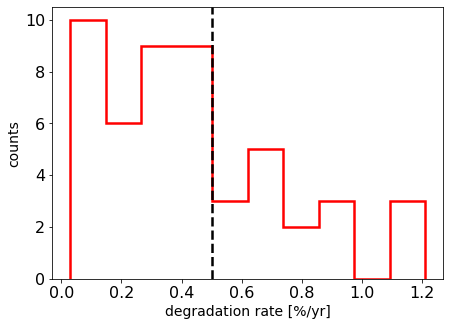

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))
_, _, _ = ax.hist(rd[0], histtype="step", linewidth=2.5, color="red")
ax.axvline(0.5, lw=2.5, color="k", ls="--")
ax.set_xlabel("degradation rate [%/yr]", fontsize=14)
ax.set_ylabel("counts", fontsize=14)

**Soiling profile**

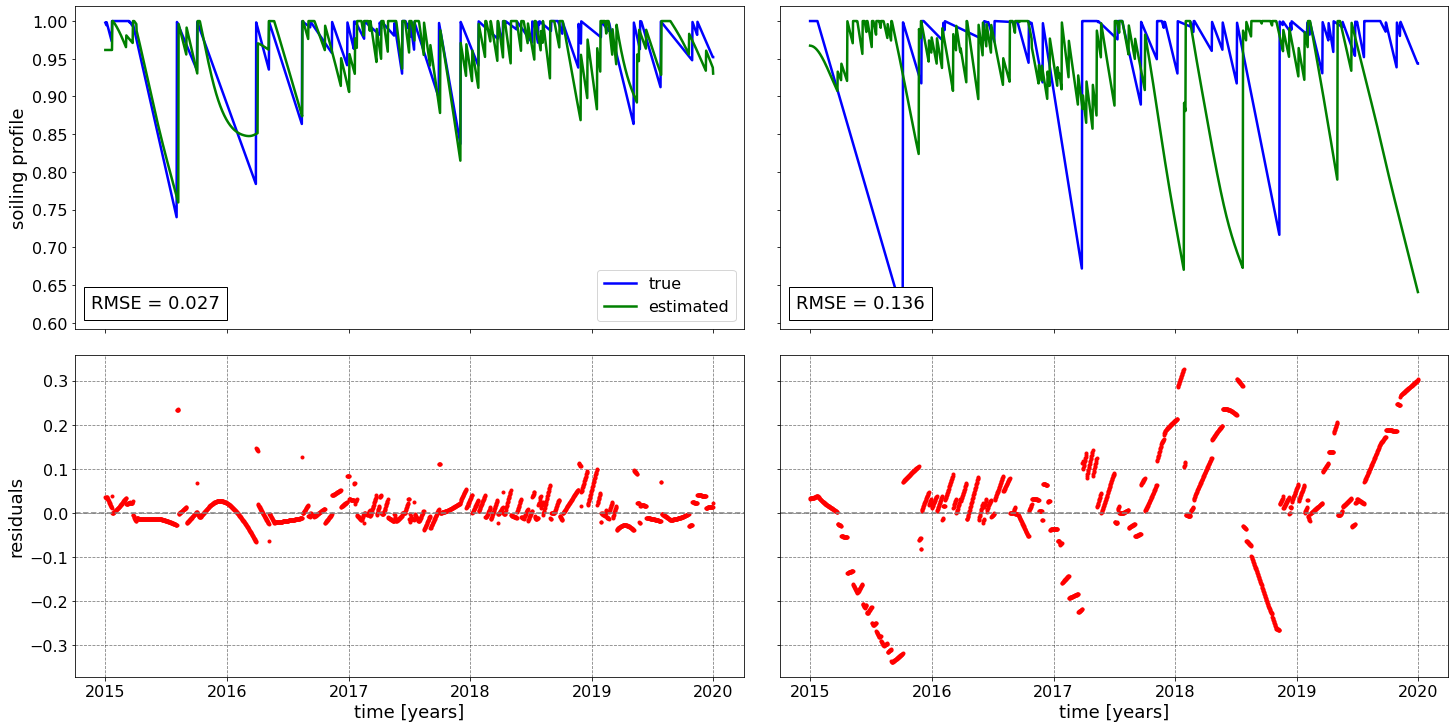

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey="row")
fig.tight_layout()


ax[0, 0].plot(sr[2].index, sr[2], color="blue", lw=2.5, ls="-", label="true")
ax[0, 0].plot(sr[3].index, sr[3], color="green", lw=2.5, ls="-", label="estimated")
ax[1, 0].plot(sr[2].index, sr[2]-sr[3], "r.")
text = AnchoredText(("RMSE = %.3f" %sr[0]), loc=3, prop=dict(size=18))
ax[0, 0].add_artist(text)
ax[0, 0].legend(loc=4, fontsize=16)

ax[0, 1].plot(sr[4].index, sr[4], color="blue", lw=2.5, ls="-", label="true")
ax[0, 1].plot(sr[5].index, sr[5], color="green", lw=2.5, ls="-", label="estimated")
ax[1, 1].plot(sr[4].index, sr[4]-sr[5], "r.")
text = AnchoredText(("RMSE = %.3f" %pi[1]), loc=3, prop=dict(size=18))
ax[0, 1].add_artist(text)

ax[0, 0].set_ylabel("soiling profile", fontsize=18)
ax[1, 0].set_ylabel("residuals", fontsize=18)
ax[1, 0].set_xlabel("time [years]", fontsize=18)
ax[1, 1].set_xlabel("time [years]", fontsize=18)
ax[1, 0].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1, 0].axhline(0., color="grey", ls="--")
ax[1, 1].grid(which="both", ls="--", color="k", alpha=0.5)
ax[1, 1].axhline(0., color="grey", ls="--")